#  INIT

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/dashboards/')

In [2]:
from cellMix_coordinator import CellMixCoordinator

In [3]:
import exploration_plots
import dashs

In [4]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [5]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

# from deconv_py.infras.cellMix.cellMix_coordinator import CellMixCoordinator

In [6]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20150208_mixture_proteinGroups.xls'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'))


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
cmc = CellMixCoordinator()
def _calc_and_display_with_cellmix(_a,_b,X,with_cellMix = False) : 
    cell_abundance_over_samples = CellProportions.fit(_a,_b.values)
    
    if with_cellMix : 
        cellMax_cell_abundance_over_samples = cmc.cell_prop_with_bash(_b,_a)
        display(cellMax_cell_abundance_over_samples)
        
    display(cell_abundance_over_samples)
    display(X)
    

# exploration - intensities

## read data - intensities

### mixture & cell specific data

In [8]:
data_factory = DataFactory(data_loader)
profile_data,profile_data_relvent_data = data_factory.build_cell_specific_profile(intensity_type='Intensity')
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(intensity_type='Intensity')

### cell proportions

In [9]:
cell_proportions_df = pd.DataFrame(index = ['Intensity NOT_CD4TCellTcm_01','Intensity NOT_BCellmemory_01','Intensity NOT_Monocytesnonclassical_01'],
                                   columns = list(range(1,9)),
                                   data =np.array(((100,0,0),(0,100,0),(0,0,100),(33,33,33),(25,25,50),(25,50,25),(50,25,25),(47.5,47.5,5.0))).T)

## build A ,X and B 

### set unique index

In [10]:
index_func = lambda x:x.split(';')[0]
_profile_data,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data,mixtures,index_func=index_func)
A = _profile_data[profile_data_relvent_data]
B = _mixtures[mixtures_relvent_data]
X = cell_proportions_df

In [11]:
B=B.rename({f:f.split('Intensity ')[1] for f in B.columns},axis=1)

X = X.rename({f:f.split('Intensity ')[1] for f in X.index},axis=0)
X = X.rename({f:'mixture'+str(f) for f in X.columns},axis=1)

A = A.rename({f:f.split('Intensity ')[1] for f in A.columns},axis=1)

## intensities analysis

### distributions
#### first - cell profiles vs cell known proportions vs cell mixtures
#### second - histogram per cell profile 

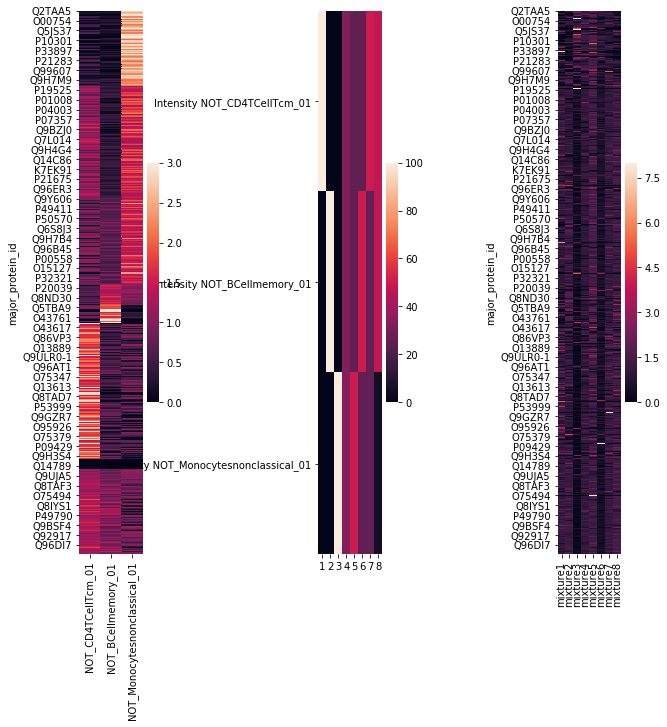

In [21]:
import scipy.cluster.hierarchy as sch

def cells_profiles(A,cell_proportions_df = None,B = None):
    n_var = len([1 for i in locals().values() if i is not None])

    res= (A.T/A.mean(axis=1)).T
    res[A==0]=0

    d = sch.distance.pdist(res) 
    L = sch.linkage(res, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')
    indexes = [res.index.tolist()[i] for i in list((np.argsort(ind)))]
    df = res.reindex(indexes, axis=0)

    args = plt.subplots(1, n_var)
    args[0].set_figheight(10)
    args[0].set_figwidth(10)
    
    if n_var >1 :
        sns.heatmap(df,ax=args[1][0])
    else :
        sns.heatmap(df,ax=args[1])

    if cell_proportions_df is not None : 
        sns.heatmap(cell_proportions_df,ax=args[1][1])

    if B is not None:
        B_ordered = B.copy(deep=True).T/B.mean(axis=1) 
        B_ordered[B.T==0] = 0
        B_ordered = B_ordered.T.reindex(indexes)
        sns.heatmap(B_ordered,ax=args[1][2])
    plt.subplots_adjust(wspace = 2)

cells_profiles(A,cell_proportions_df,B)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


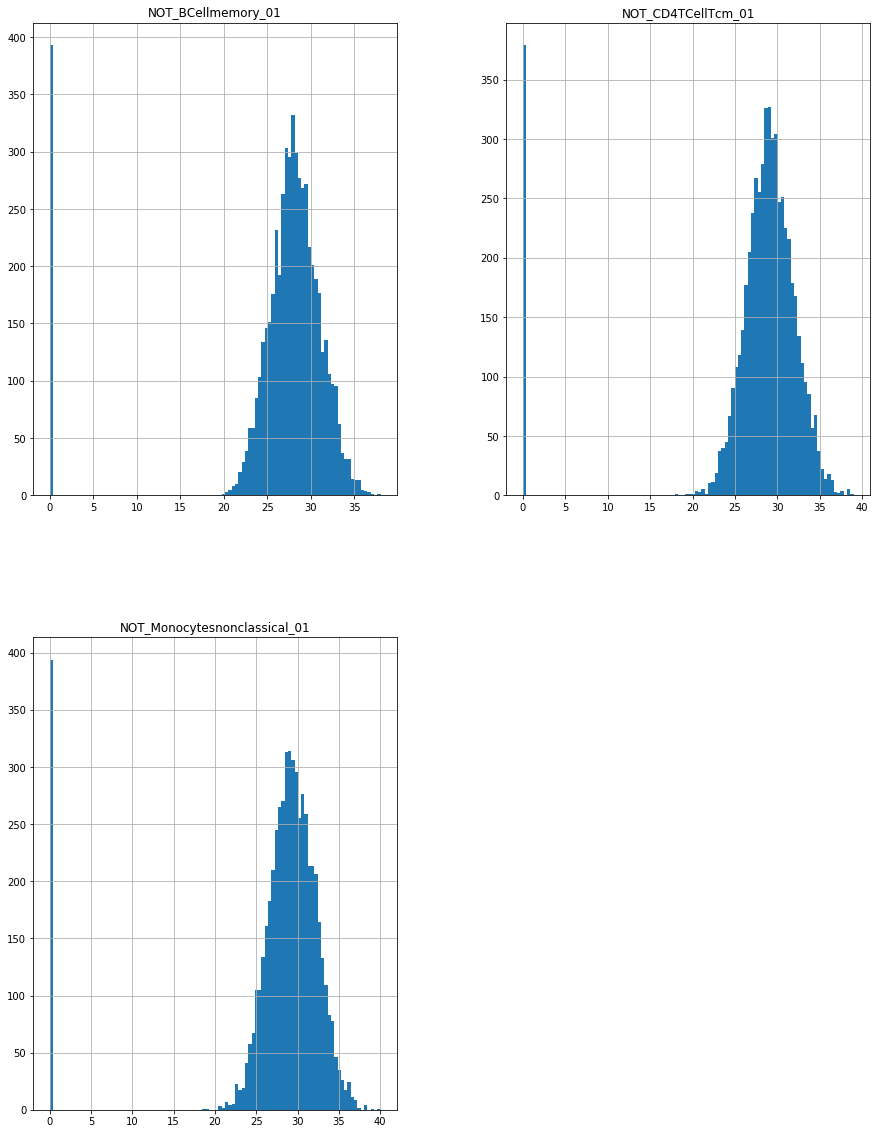

In [13]:
def values_histogram_per_cell_profile(A):
    fig = plt.figure(figsize = (15,20))
    ax = fig.gca()
    np.log2(A+1).hist(bins=100,ax=ax)
values_histogram_per_cell_profile(A)

### correlation mixture vs expcted_mixture - pearson

In [14]:
def corr_expcted_vs_mixture(expcted_b,B,method  = "pearson"):
    corr_per_mixture_df = pd.DataFrame(index= B.columns)

    for i in np.linspace(0.05,0.95,19) :
        trh = round(i,2)

        for mixture_idx in B:
            mixture =np.log2(B[mixture_idx])
            mixture = B[mixture_idx]
            mixture[B[mixture_idx] == 0] = 0
            mixture_trh = mixture.quantile(trh)
            relevant_proteins = mixture[mixture>mixture_trh].index

            _expcted_b = np.log2(expcted_b[mixture_idx])
            _expcted_b = expcted_b[mixture_idx]
            _expcted_b[expcted_b[mixture_idx] ==0] = 0
            corr = _expcted_b.loc[relevant_proteins].corr(mixture.loc[relevant_proteins],method = method)
            corr_per_mixture_df.ix[mixture_idx,trh] = corr
    corr_per_mixture_df.T.plot(title=f"correlation mixture vs expcted_mixture - {method}")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


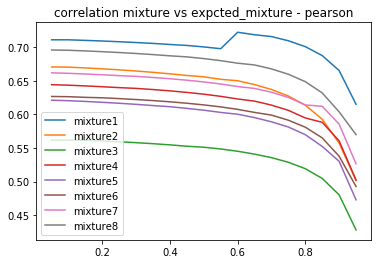

In [15]:
expcted_b = A.dot(X)
corr_expcted_vs_mixture(expcted_b,B)

### correlation mixture vs expcted_mixture - speraman

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


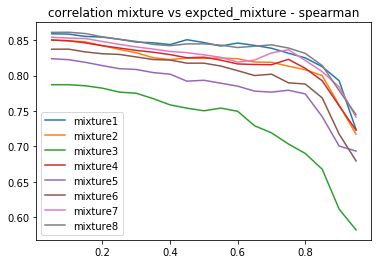

In [16]:
corr_expcted_vs_mixture(expcted_b,B,"spearman")

### number of unexpcted zeros - not zero in the profile but zero in the mixture
#### x axis  - the number of mixtures where the gene is zero (but not in the profile)

1335

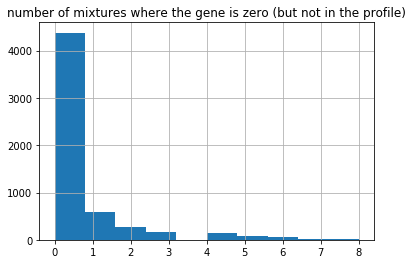

In [17]:
def unexpcted_zeros_per_mixture(expcted_b,B) : 
    number_of_unexpcted_zeros = ((expcted_b != 0)&(B==0)).sum(axis=1)
    display((number_of_unexpcted_zeros >0).sum())
    display(number_of_unexpcted_zeros.hist())
    plt.title("number of mixtures where the gene is zero (but not in the profile)")
unexpcted_zeros_per_mixture(expcted_b,B)

### scatter mixture vs expcted_mixture

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


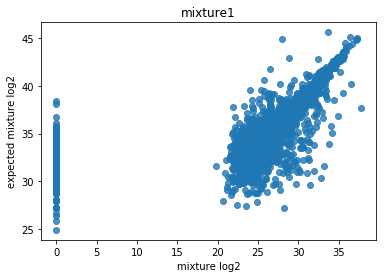

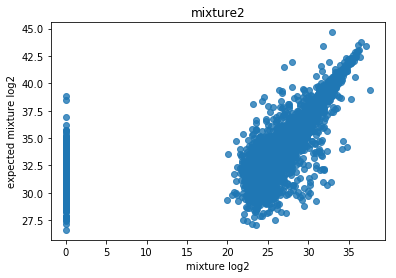

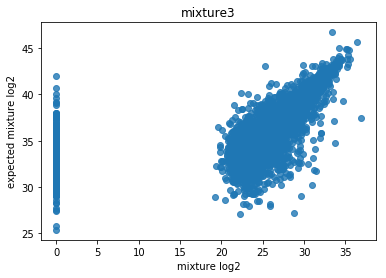

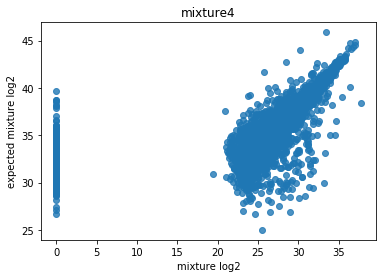

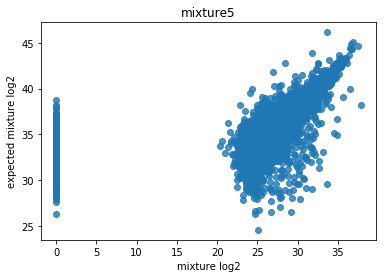

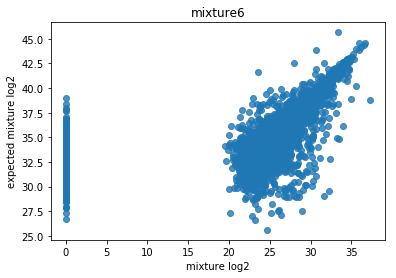

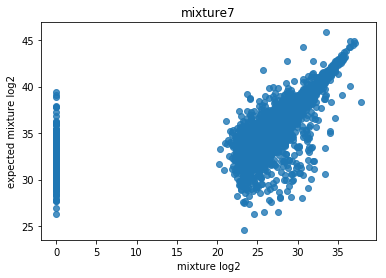

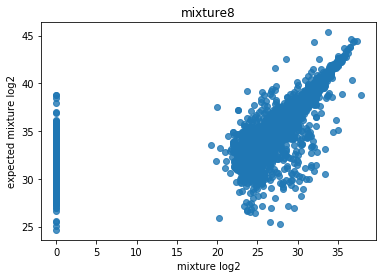

In [18]:
def scatter_mixture_vs_expcted_mixture(expcted_mixture,B):
    for i,mixture_idx in enumerate(B):
        mixture =np.log2(1+B[mixture_idx])
        expcted_mixture = np.log2(expcted_b[mixture_idx])

        sns.regplot(mixture,expcted_mixture)
        plt.title(mixture_idx)
        plt.xlabel( "mixture log2")
        plt.ylabel ("expected mixture log2")
        plt.show()
scatter_mixture_vs_expcted_mixture(expcted_b,B)

### histogram of - the expected values of  where we have unexpected zeros(in the mixture) vs all expected values

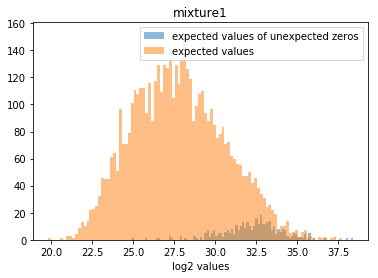

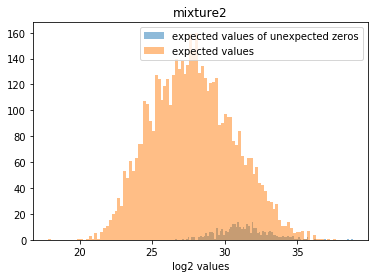

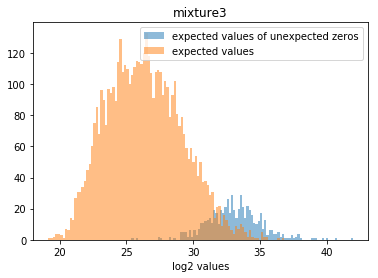

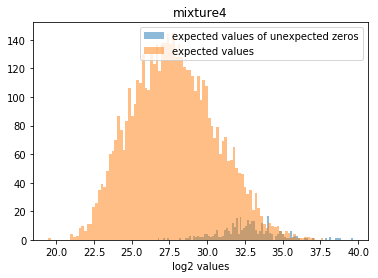

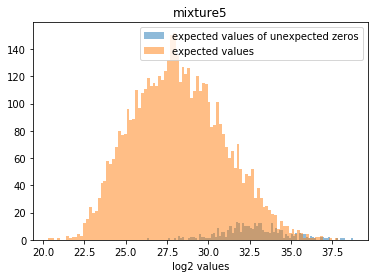

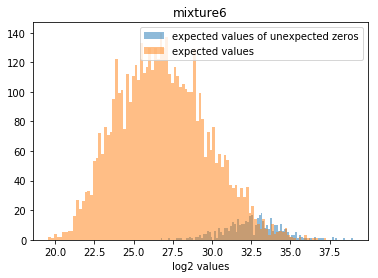

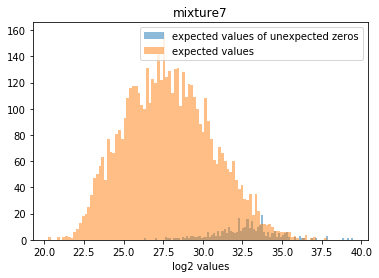

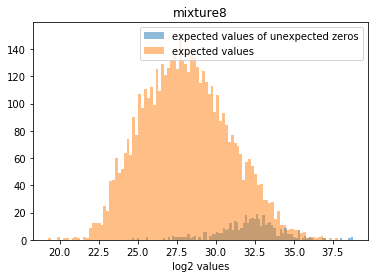

In [19]:
def expected_values_of_unexpected_zeros(expcted_b,B):
    for mixture_idx in B:
        zeros = np.log2(1+expcted_b[mixture_idx][((expcted_b[mixture_idx] != 0)&(B[mixture_idx]==0))])
        all_data = np.log2(1+B[mixture_idx][B[mixture_idx] != 0])

        plt.hist(zeros, 100, alpha=0.5, label="expected values of unexpected zeros")
        plt.hist(all_data, 100, alpha=0.5, label="expected values")
        plt.title(mixture_idx)
        plt.xlabel("log2 values")
        plt.legend(loc = "upper right")
        plt.show()
expected_values_of_unexpected_zeros(expcted_b,B)